In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scipy.cluster import hierarchy
from sklearn import metrics

# Load data

In [3]:
data = pd.read_excel('GCI_Dataset_2007-2017.xlsx',
              sheet_name='Data', skiprows = 3) 

In [4]:
countries = pd.read_excel('GCI_Dataset_2007-2017.xlsx',
              sheet_name='Entities', skiprows = 2) 


## Initial data cleaning

Select only columns needed for this analysis

### Data df

In [5]:
# Clean not needed columns
countries.drop(['Entity type'], axis = 1, inplace = True)

#change column name
countries.columns = ['Entity code', 'Entity', 'income_group', 'econ_region', 'geo_region']

In [7]:
countries.sample(5)

,Entity code,Entity,income_group,econ_region,geo_region
0,ALB,Albania,Upper middle income,Emerging and Developing Europe,Europe and North America
137,TLS,Timor-leste,Lower middle income,Emerging and Developing Asia,East Asia and Pacific
112,PRI,Puerto Rico,High income,NaN,Latin America and the Caribbean
51,GRC,Greece,High income,Advanced economies,Europe and North America
149,YEM,Yemen,Lower middle income,"Middle East, North Africa, and Pakistan",Middle East and North Africa


### Countries df

In [6]:
data.drop(['Unnamed: 160', 'East Asia and Pacific', 'East Asia and Pacific', 'Latin America and the Caribbean',
          'Europe and North America', 'Eurasia', 'Sub-Saharan Africa', 
           'South Asia', 'Middle East and North Africa'], axis = 1, inplace = True)

In [8]:
data.sample(3)

,Placement,Dataset,Edition,GLOBAL ID,Code GCR,Series,Series unindented,Attribute,Albania,Algeria,...,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Viet Nam,Yemen,Zambia,Zimbabwe
5678,98,Global Competitiveness Index,2009-2010,EOSQ134,7.03,"7.03 Hiring and firing practices, 1...","Hiring and firing practices, 1-7 (best)",Value,4.68962,3.19786,...,4.72327,4.85556,4.12999,5.36139,2.77039,2.14076,4.56668,NaN,4.39801,2.67549
381,64,Global Competitiveness Index,2017-2018,ENROL2GR,5.01,5.01 Secondary education enrollment...,"Secondary education enrollment, gross %*",Source,"UNESCO Institute for Statistics, [i]Data Centr...","UNESCO Institute for Statistics, [i]Data Centr...",...,"UNESCO Institute for Statistics, [i]Data Centr...",World Economic Forum,"UNESCO Institute for Statistics, [i]Data Centr...","UNESCO Institute for Statistics, [i]Data Centr...","UNESCO Institute for Statistics, [i]Data Centr...","UNESCO Institute for Statistics, [i]Data Centr...",Ministry of Education,"UNESCO Institute for Statistics, [i]Data Centr...",Ministry of Education,"UNESCO Institute for Statistics, [i]Data Centr..."
2048,27,Global Competitiveness Index,2015-2016,EOSQ098,1.2,1.20 Protection of minority shareho...,Protection of minority shareholders’ interests...,Rank,67,98,...,134,15,10,17,35,135,109,NaN,38,70


# Make education & internet - focus data set for 2018

More data cleaning to 
+ Subset the dataset into a df containing only our attributes of interest (see selected global_id_list).
+ Select only data in 2017-2018 report
+ Clean attribute names
+ Drop 19 countries with missing data
+ Pivot df into usable format
+ Merge 'data' df with 'countries' df for country categeory

In [9]:
# Select attributes needed
global_id_list = ['EOSQ129',
'ENROL1NET',
'EOSQ128',
'EOSQ130',
'EOSQ084',
'NETUSERPCT',
'BBSUBPC',
'INTBDWIDUSER']

In [10]:
# Select data with selected attribute 
edu_df = data[data['GLOBAL ID'].isin(global_id_list)]

# Select data from 2017-2018 report
edu_df = edu_df[edu_df.Edition == '2017-2018']

# Select value only (exclude rank, report, etc.)
edu_df = edu_df[edu_df.Attribute.isin(['Value'])]

# Drop not needed columns
edu_df.drop(['Placement','Dataset','Edition','GLOBAL ID','Code GCR','Series','Attribute'], axis = 1, inplace = True)

In [11]:
# Show 19 Countries with missing data
missing_countries = edu_df.columns[edu_df.isnull().any()]
missing_countries

Index(['Angola', 'Barbados', 'Belize', 'Bolivia', 'Burkina Faso',
       'Côte d'Ivoire', 'Gabon', 'Guyana', 'Haiti', 'Libya', 'Macedonia, FYR',
       'Madagascar', 'Myanmar', 'Puerto Rico', 'Slovak Republic', 'Suriname',
       'Syria', 'Timor-Leste'],
      dtype='object')

In [12]:
# exclude countries with missing data
edu_df.drop(missing_countries, axis = 1, inplace = True)

edu_df.head()

,Series unindented,Albania,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,...,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Viet Nam,Yemen,Zambia,Zimbabwe
348,"Quality of primary education, 1-7 (best)",5.05699,3.40836,3.31086,4.25528,5.3779,4.76358,4.19407,4.74835,3.10414,...,4.60347,5.3988,5.04819,5.52632,3.43285,2.76061,3.42251,2.37473,3.35523,4.19186
354,"Primary education enrollment, net %*",95.5173,97.0621,99.3468,96.0742,97.0328,98.1,94.1426,96.4285,90.5086,...,96.1755,93.375,99.8543,93.7542,94.2177,89.8568,97.9651,84.8373,87.4041,85.8624
396,"Quality of the education system, 1-7 (best)",4.28658,3.21236,3.17313,3.84729,5.06772,4.22853,4.4004,4.63919,3.39629,...,3.86212,5.27967,4.67399,5.62064,2.70358,2.56436,3.63319,2.2852,3.75072,4.04583
402,"Quality of math and science education, 1-7 (best)",4.29543,3.62119,3.14621,4.72783,4.79443,4.57015,4.16795,4.78052,3.17483,...,4.84127,5.34237,4.57445,5.44542,2.95702,2.81751,3.73783,2.43551,3.66483,4.1466
414,"Internet access in schools, 1-7 (best)",5.27142,3.27643,3.95256,4.25431,6.00692,5.03867,4.88868,4.9606,3.26519,...,4.80328,5.8288,5.70223,5.87299,5.60296,3.32454,4.05935,1.59184,3.20338,3.18219


In [13]:
# clean attribute names
edu_df['Series unindented'] = edu_df['Series unindented'].apply(lambda x: x.strip('*'))

# Print all attribute
attribute_val = edu_df['Series unindented']
attribute_val = list(attribute_val)
attribute_val

['Quality of primary education, 1-7 (best)',
 'Primary education enrollment, net %',
 'Quality of the education system, 1-7 (best)',
 'Quality of math and science education, 1-7 (best)',
 'Internet access in schools, 1-7 (best)',
 'Individuals using Internet, %',
 'Fixed broadband Internet subscriptions/100 pop.',
 'Int’l Internet bandwidth, kb/s per user']

In [14]:
# melt into long-form format for analysis 
edu_df = pd.melt(edu_df, id_vars=['Series unindented'], var_name = 'country', value_name = 'value')

# merge with entity data
edu_df = edu_df.merge(countries, how = 'left', left_on = 'country', right_on = 'Entity').drop(['Entity'], axis = 1)

#Change col name to simpler names
new_col_names = ['attribute', 'country', 'value', 'entity_code', 'income_group', 'econ_region', 'geo_region']
edu_df.columns = new_col_names

# edit data type
edu_df.value = edu_df.value.astype('float32')

edu_df.sample(5)

,attribute,country,value,entity_code,income_group,econ_region,geo_region
1037,"Individuals using Internet, %",Venezuela,60.000000,VEN,Upper middle income,Latin America and the Caribbean,Latin America and the Caribbean
133,"Individuals using Internet, %",Bulgaria,59.825546,BGR,Upper middle income,Emerging and Developing Europe,Europe and North America
137,"Primary education enrollment, net %",Burundi,94.148277,BDI,Low income,Sub-Saharan Africa,Sub-Saharan Africa
271,"Int’l Internet bandwidth, kb/s per user",Ecuador,43.677147,ECU,Upper middle income,Latin America and the Caribbean,Latin America and the Caribbean
866,"Quality of the education system, 1-7 (best)",Singapore,5.815630,SGP,High income,Advanced economies,East Asia and Pacific


# Explore data

## Explore Countries cateogies 

Countries are categoried with 3 methods: income group, geographical region, and economic region. 

In this section, I visualize counts of labels in each categories.

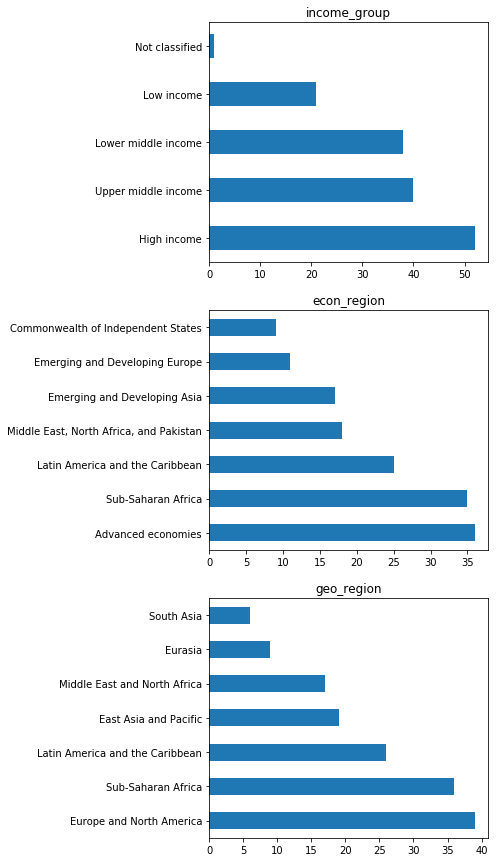

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(5,15))

for val, ax in zip(['income_group','econ_region','geo_region' ], axes.flatten()):
    countries[val].value_counts().plot(kind='barh', ax = ax)
    ax.set_title('{}'.format(val))
    ax.set_xlabel('')
    
plt.show()

# Explore attributes

There are 8 attributes of interest, of which 4 are related to education quality and the other 4 reflects the level of internet access.

In this section I visualize the distribution of each attributes. 

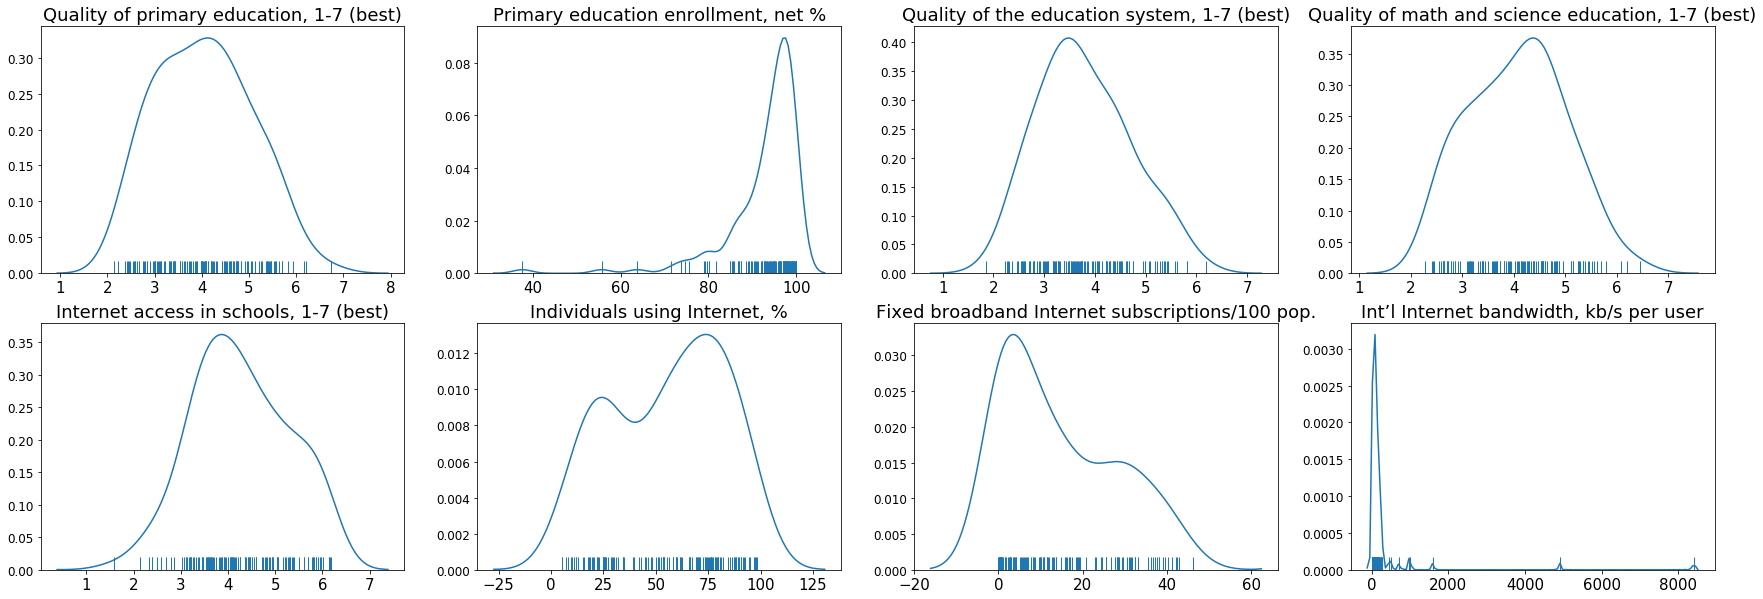

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(30,10))

for val, ax in zip(attribute_val, axes.flatten()):
    a = edu_df[edu_df.attribute == val]['value']
    sns.distplot(a, hist=False, rug=True, ax = ax)
    ax.set_title('{}'.format(val), fontsize = 18)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=12)
plt.show()

## Explore 8 Attributes by 3 Country Categories

In this section, I showed the descriptive statistic (mean) of 8 attributes by 3 country categories (income group, econ region, and geo region)


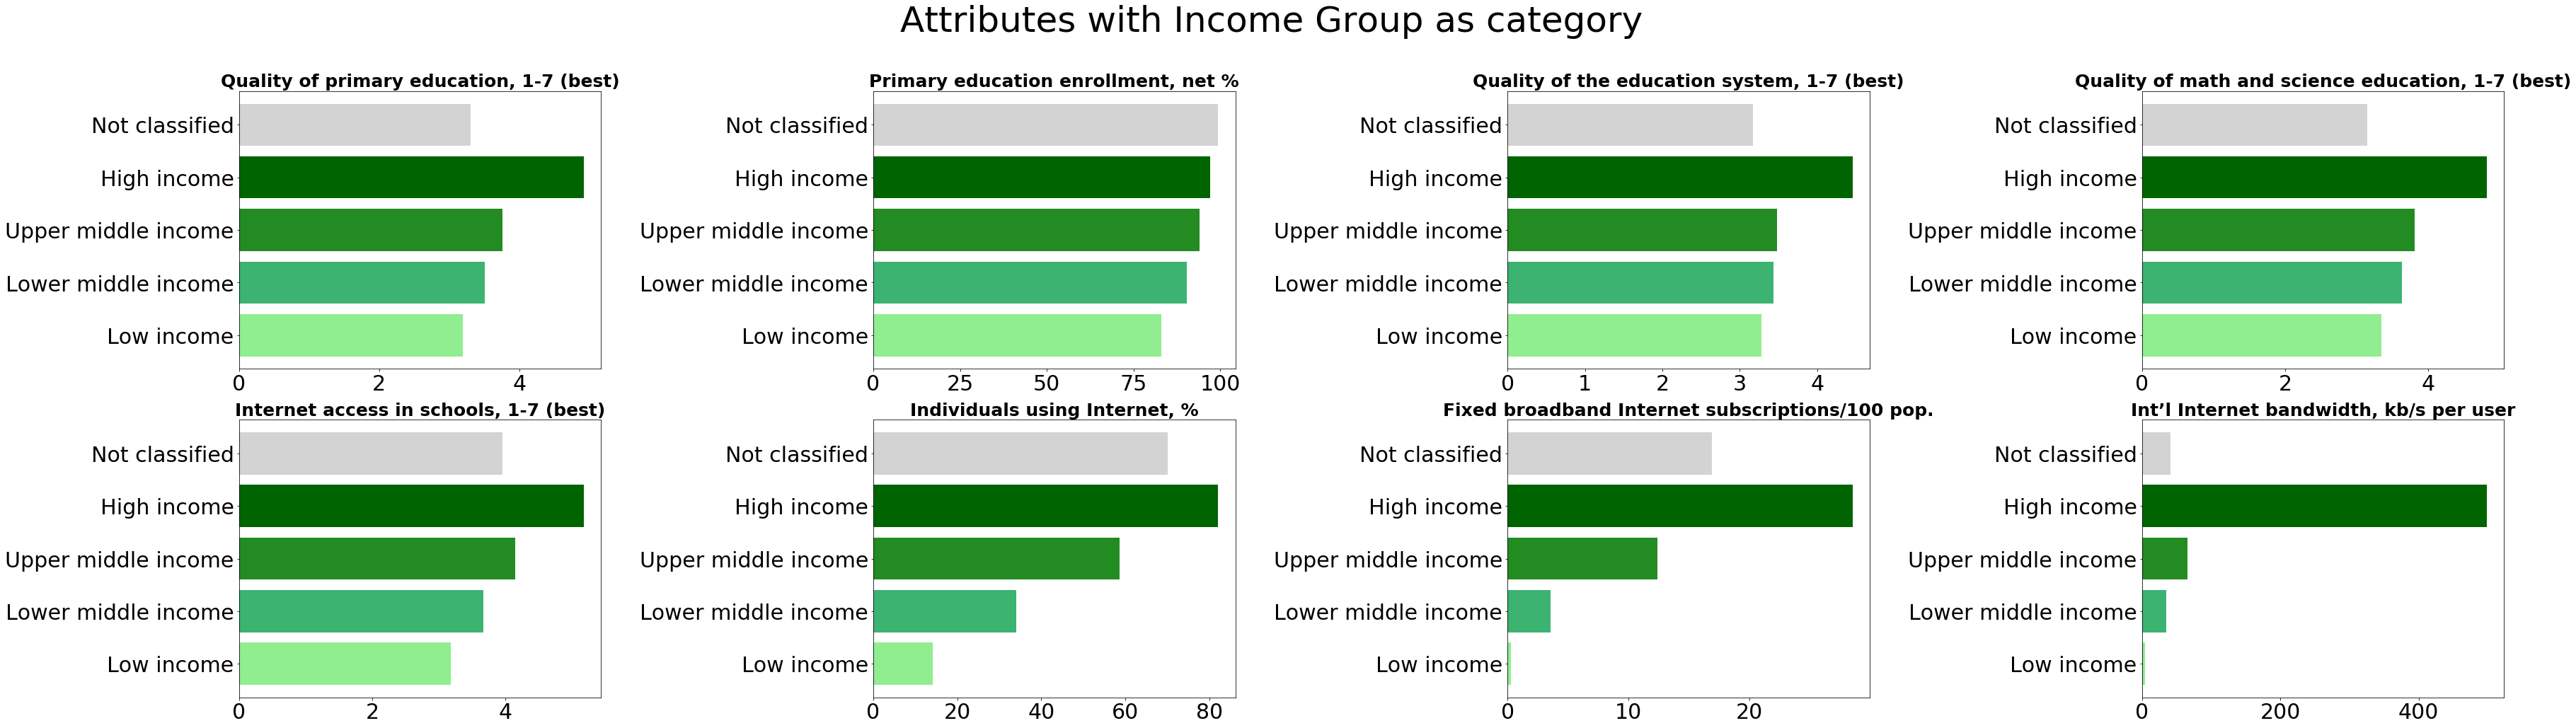

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(50,15))

# specify order of categories
order = {'Low income': 1, 'Lower middle income': 2, 'Upper middle income': 3, 'High income': 4, 'Not classified': 5}

for val, ax in zip(attribute_val, axes.flatten()):
    # make dataset with selected attribute
    temp = edu_df[edu_df.attribute == val].copy()

    # make groupby dataset to sort
    temp2 = pd.DataFrame(temp.groupby(['income_group'])['value']\
    .mean())
    temp2['rank'] = temp2.index.map(order)
    temp2.sort_values('rank', inplace = True)

    # color
    color_list = []
    for attr in temp2.index:
        if attr in ['Not classified']:
            color_list.append('lightgrey')
        elif attr in ['Low income']:
            color_list.append('lightgreen')
        elif attr in  ['Lower middle income']:
            color_list.append('mediumseagreen')
        elif attr in  ['Upper middle income']:
            color_list.append('forestgreen')
        else:
            color_list.append('darkgreen')
    # chart bar plot
    ax.barh(temp2.index, temp2.value, color = color_list)
    
    # chart params
    ax.set_title('{}'.format(val), fontsize = 25, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

    
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.suptitle('Attributes with Income Group as category', fontsize = 50)
plt.show()

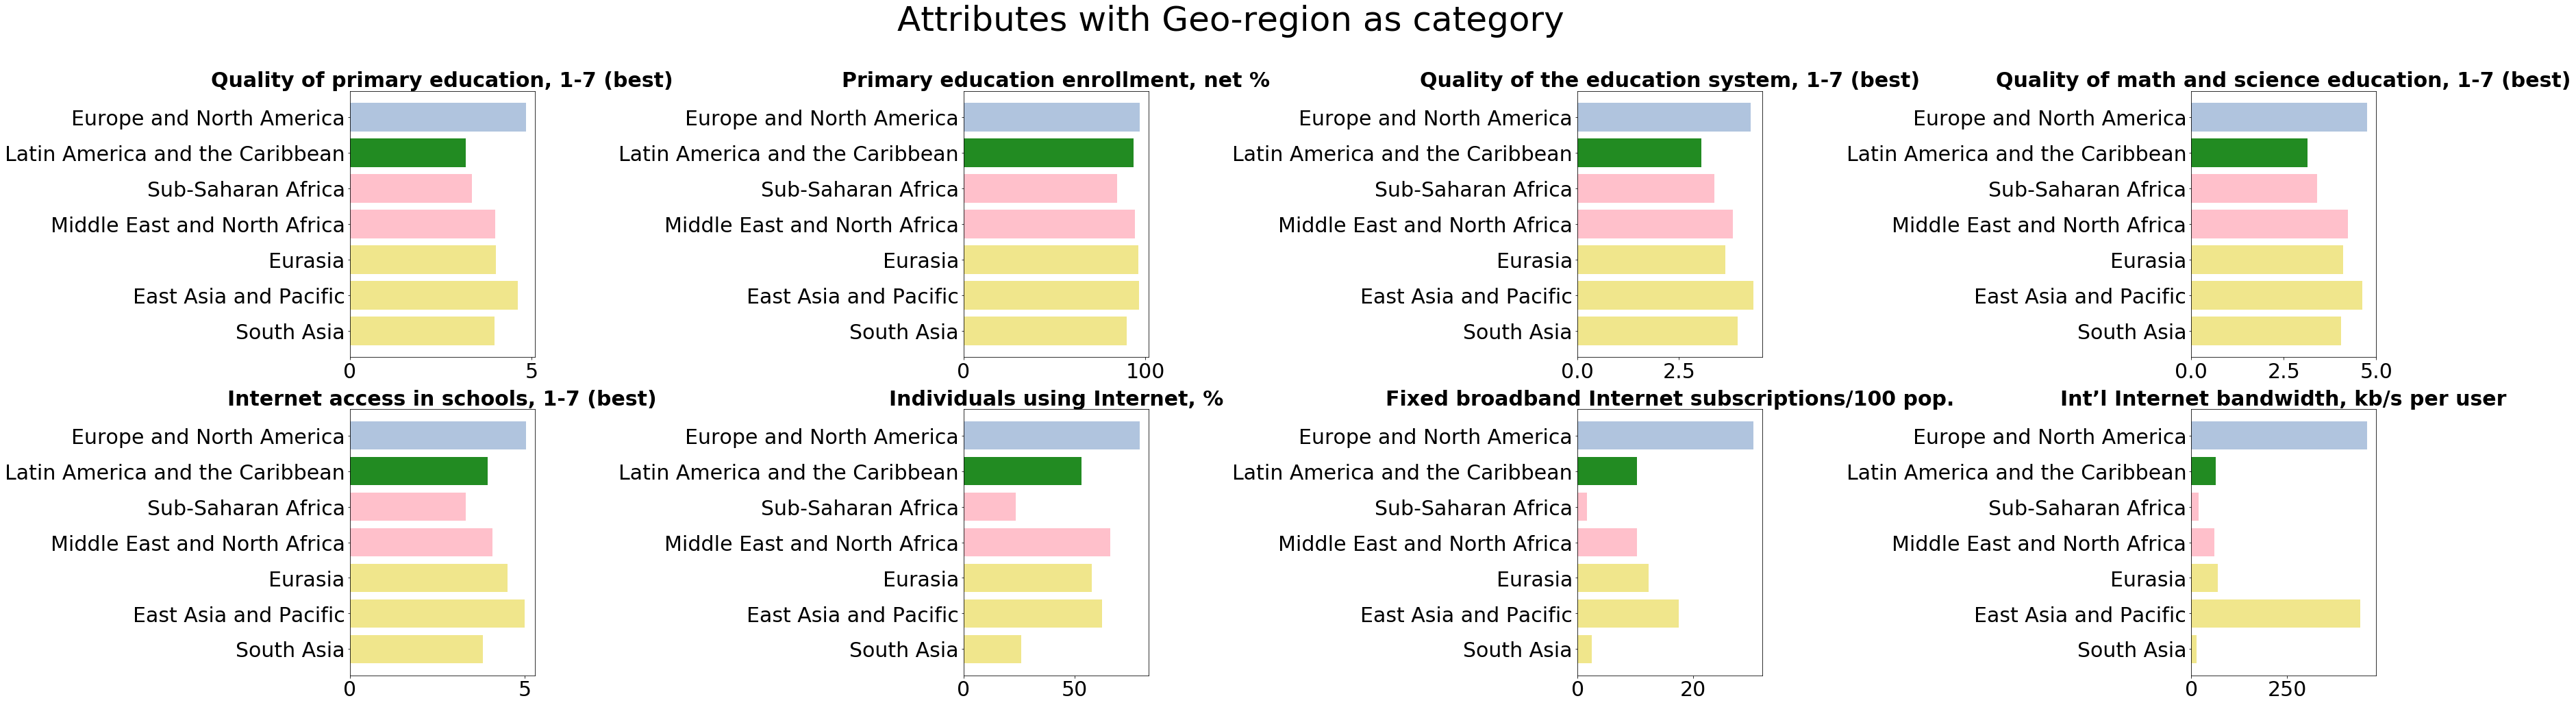

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(50,15))

# specify order of categories
order = {'Europe and North America': 7, 'Latin America and the Caribbean': 6, 
         'Sub-Saharan Africa': 5, 'Middle East and North Africa': 4, 'Eurasia': 3,
        'East Asia and Pacific': 2, 'South Asia': 1}

for val, ax in zip(attribute_val, axes.flatten()):
    # make dataset with selected attribute
    temp = edu_df[edu_df.attribute == val].copy()

    # make groupby dataset to sort
    temp2 = pd.DataFrame(temp.groupby(['geo_region'])['value']\
    .mean())
    temp2['rank'] = temp2.index.map(order)
    temp2.sort_values('rank', inplace = True)
    
    # color
    color_list = []
    for attr in temp2.index:
        if attr in ['Europe and North America']:
            color_list.append('lightsteelblue')
        elif attr in ['Latin America and the Caribbean']:
            color_list.append('forestgreen')
        elif attr in  ['Sub-Saharan Africa', 'Middle East and North Africa']:
            color_list.append('pink')
        else:
            color_list.append('khaki')
    
    # chart bar plot
    ax.barh(temp2.index, temp2.value, color = color_list)
    
    # chart params
    ax.set_title('{}'.format(val), fontsize = 30, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

    
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    
fig.suptitle('Attributes with Geo-region as category', fontsize = 50)
plt.show()

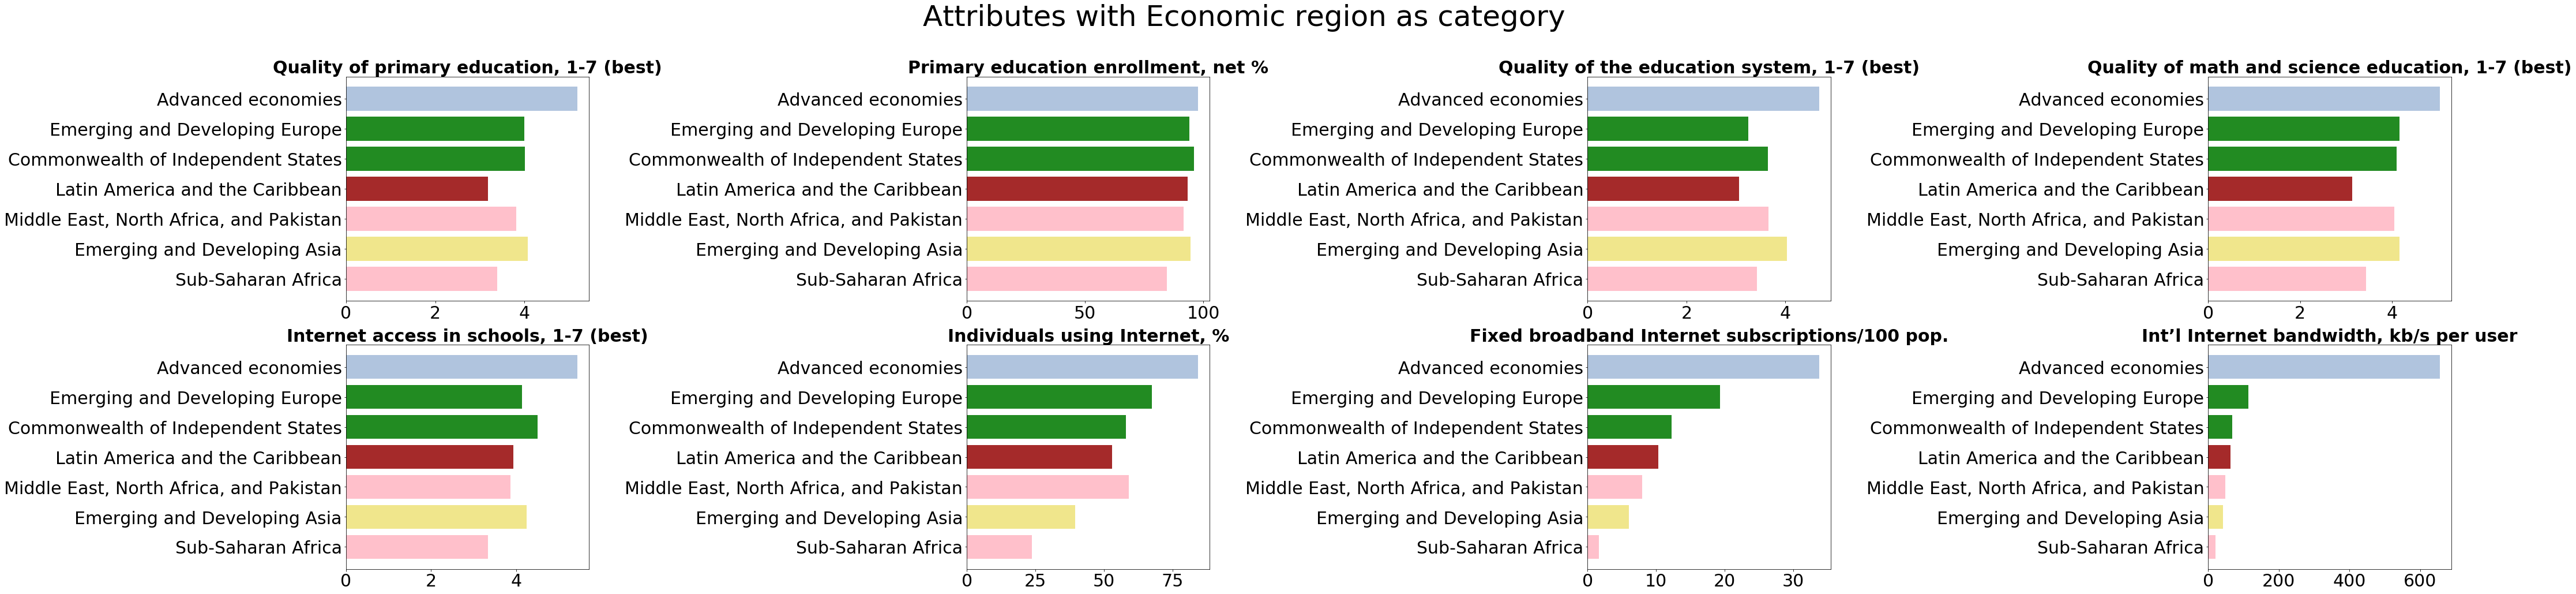

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(60,15))

# specify order of categories
order = {'Advanced economies': 7, 'Emerging and Developing Europe': 6, 
         'Commonwealth of Independent States': 5, 'Latin America and the Caribbean': 4, 'Middle East, North Africa, and Pakistan': 3,
        'Emerging and Developing Asia': 2, 'Sub-Saharan Africa': 1}

for val, ax in zip(attribute_val, axes.flatten()):
    # make dataset with selected attribute
    temp = edu_df[edu_df.attribute == val].copy()

    # make groupby dataset to sort
    temp2 = pd.DataFrame(temp.groupby(['econ_region'])['value']\
    .mean())
    temp2['rank'] = temp2.index.map(order)
    temp2.sort_values('rank', inplace = True)
    
    # color
    color_list = []
    for attr in temp2.index:
        if attr in ['Advanced economies']:
            color_list.append('lightsteelblue')
        elif attr in ['Emerging and Developing Europe', 'Commonwealth of Independent States']:
            color_list.append('forestgreen')
        elif attr in  ['Sub-Saharan Africa', 'Middle East, North Africa, and Pakistan']:
            color_list.append('pink')
        elif attr in ['Latin America and the Caribbean']:
            color_list.append('brown')
        else:
            color_list.append('khaki')
    
    # chart bar plot
    ax.barh(temp2.index, temp2.value, color = color_list)
    
    # chart params
    ax.set_title('{}'.format(val), fontsize = 30, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)

    
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.suptitle('Attributes with Economic region as category', fontsize = 50)
plt.show()

# Clustering

After exploring different clustering techniques, I decided to use the Hierarchical clustering algorithm to group similar objects into groups called clusters. Specifically, Agglomerative Clustering (bottom-up approach) was employed, which used the euclidean distance as the measure of distance between points and ward linkage to calculate the proximity of clusters.

Kmeans was tried but not used in this final report because our data does not have distinct sphere-like clusters, which inhibit the performance of Kmeans. 

In [22]:
clustering_data = edu_df.copy()

# Drop geo region from clustering because geo region does not inheritly carry information about internet + education. 
clustering_data.drop('geo_region', axis = 1, inplace = True)

In [24]:
# Pivot data so that country is unique index for clustering 
clustering_data = clustering_data[['entity_code', 'attribute', 'value']]\
    .pivot(index="entity_code", columns='attribute',values="value").reset_index()

# merge back with entity data
clustering_data = clustering_data.merge(countries, how = 'left', left_on = 'entity_code', right_on = 'Entity code')\
    .drop(['Entity code', 'entity_code'], axis = 1)

# rename column
clustering_data.rename(columns={'Entity':'country'}, inplace=True)

In [25]:
clustering_data.head(3)

,Fixed broadband Internet subscriptions/100 pop.,"Individuals using Internet, %","Internet access in schools, 1-7 (best)","Int’l Internet bandwidth, kb/s per user","Primary education enrollment, net %","Quality of math and science education, 1-7 (best)","Quality of primary education, 1-7 (best)","Quality of the education system, 1-7 (best)",country,income_group,econ_region,geo_region
0,8.227068,66.363441,5.271418,56.964111,95.517311,4.295430,5.056987,4.286576,Albania,Upper middle income,Emerging and Developing Europe,Europe and North America
1,13.299810,90.600006,5.828802,133.748688,93.375000,5.342373,5.398798,5.279667,United Arab Emirates,High income,"Middle East, North Africa, and Pakistan",Middle East and North Africa
2,16.938744,70.150764,3.952558,41.129974,99.346786,3.146213,3.310864,3.173132,Argentina,Not classified,Latin America and the Caribbean,Latin America and the Caribbean


In [26]:
features = clustering_data.copy()
features.drop('country', axis = 1, inplace = True)

#Creating dummy variables
income_dummy = pd.get_dummies(features['income_group'])
econ_dummy = pd.get_dummies(features['econ_region'])
geo_dummy = pd.get_dummies(features['geo_region'])

#Concatenating the dummy variables to the original dataset 
features=pd.concat([features, income_dummy,econ_dummy, geo_dummy],axis=1)
features.drop(['income_group', 'econ_region', 'geo_region'], axis = 1, inplace = True)

In [27]:
value = features.values
#Passing the values of the dataset to Min-Max-Scaler
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(value)
X = pd.DataFrame(x_scaled,columns=features.columns)

In [28]:
# Hierarchical Clustering by sklearn module
HClustering = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters=3).fit(X)

y_HClustering = HClustering.fit_predict(X)

print(y_HClustering)

#Check ingroup similarity
print("silhouette_score : "+str(metrics.silhouette_score(X, y_HClustering)))

#Make file with grouping
data_predicted = clustering_data.copy()
data_predicted["prediction"] = y_HClustering

[0 0 0 0 1 1 0 2 1 2 0 0 0 0 0 0 0 2 1 1 0 0 2 2 0 2 0 1 1 1 1 0 0 0 0 1 1
 2 1 1 1 0 2 2 2 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 2 0 0 1 0 0 0 2 0 2 1 1
 1 0 0 0 2 1 0 0 2 0 2 2 0 2 2 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 2 0 2 1 2 0
 0 1 1 2 2 2 0 0 0 0 0 1 2 2 0 0 1 0 0 0 2 2 2]
silhouette_score : 0.32807603


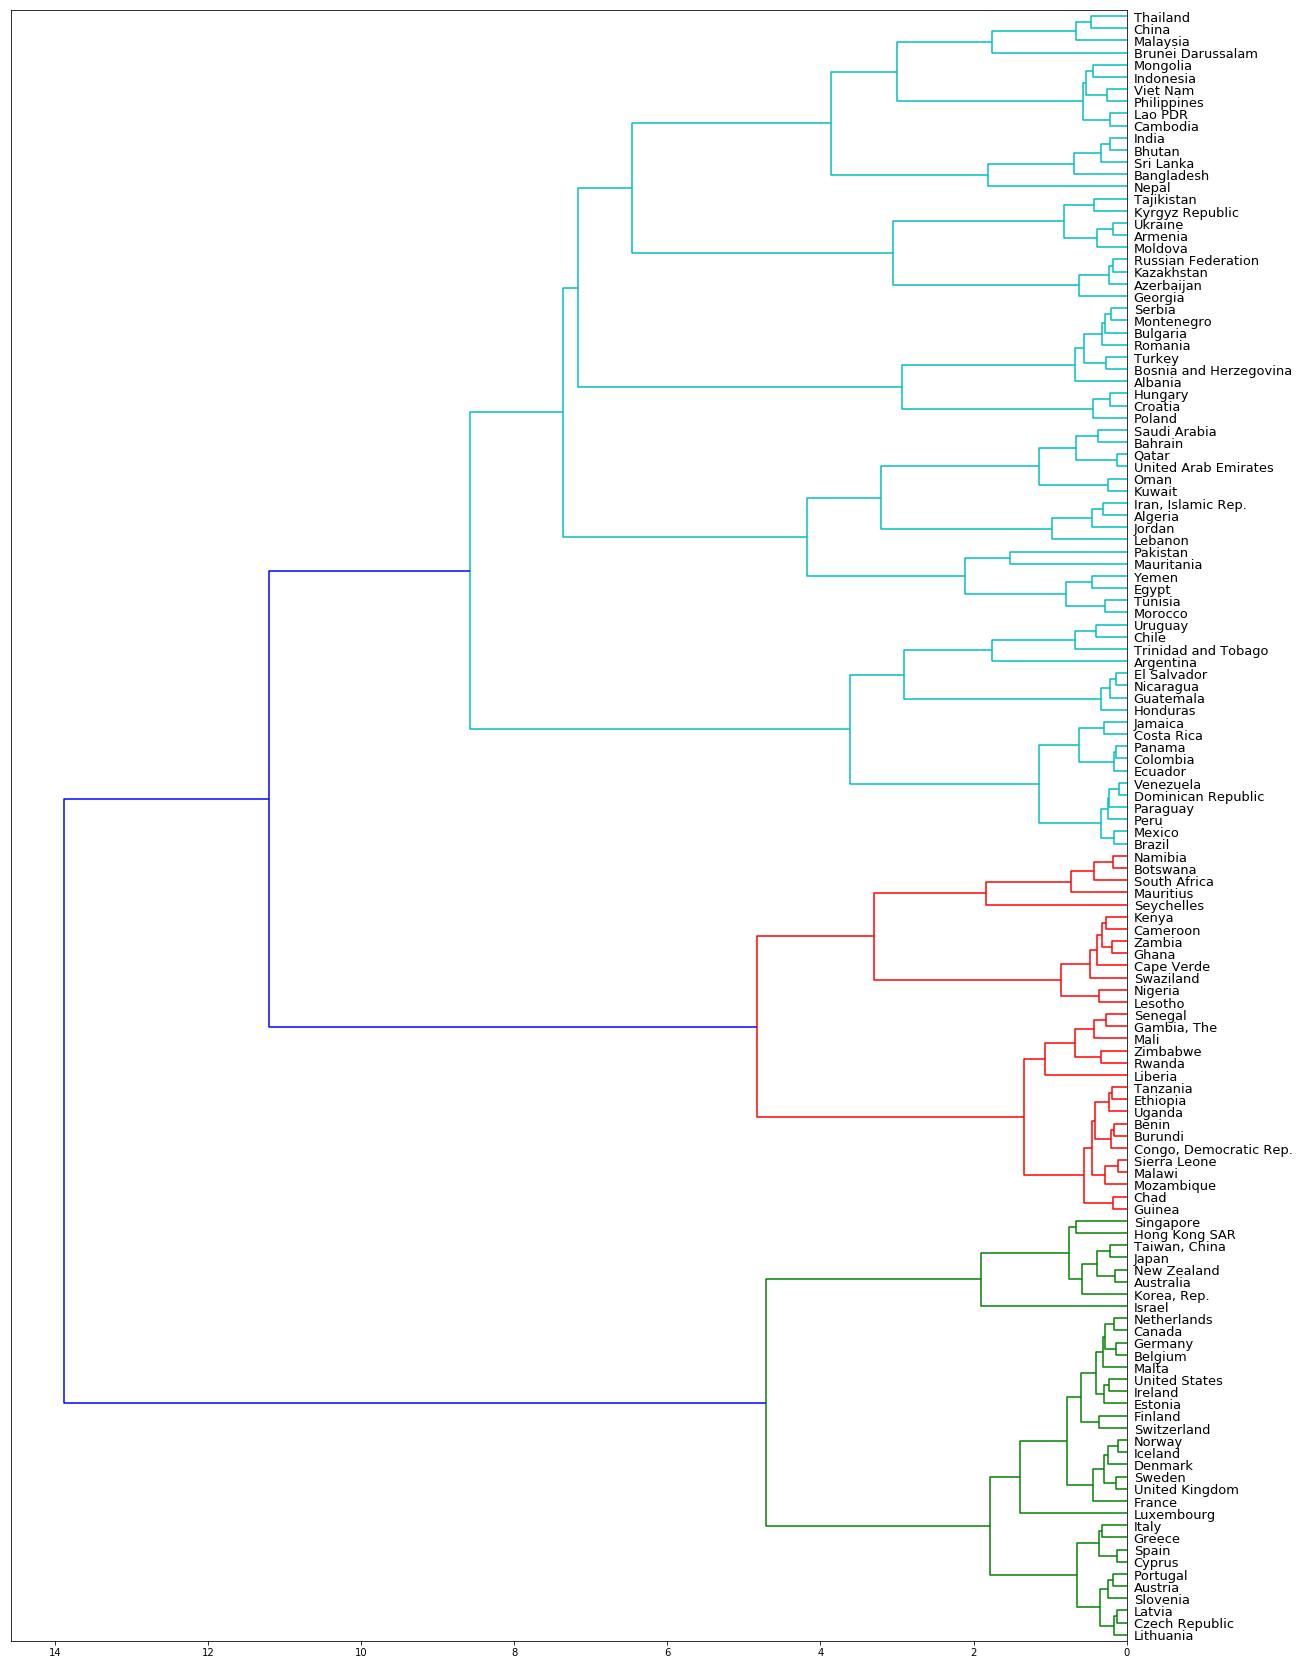

In [29]:
# Dendrogram – scipy module
Z = hierarchy.linkage(X , 'ward')

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(20,30))
dn = hierarchy.dendrogram(Z, labels = clustering_data.country.values, orientation = 'left', ax = ax)
ax.tick_params(axis='y', which='major', labelsize=13)

# save to file
plt.savefig('dendro.png', format='png', bbox_inches='tight')

#Show plot
plt.show()

In [30]:
# Examine statistics of new clusters
data_predicted.groupby('prediction').mean()

,Fixed broadband Internet subscriptions/100 pop.,"Individuals using Internet, %","Internet access in schools, 1-7 (best)","Int’l Internet bandwidth, kb/s per user","Primary education enrollment, net %","Quality of math and science education, 1-7 (best)","Quality of primary education, 1-7 (best)","Quality of the education system, 1-7 (best)"
prediction,,,,,,,,
0,10.399714,54.270977,4.090453,63.114002,93.693398,3.845969,3.747898,3.511083
1,33.725483,84.440514,5.445004,655.459045,97.917656,5.038624,5.187424,4.676874
2,1.630512,23.667864,3.337949,20.377274,84.622185,3.432778,3.384614,3.421658


In [31]:
data_predicted.groupby('prediction').describe()

Fixed broadband Internet subscriptions/100 pop.             \
                                                     count       mean   
prediction                                                              
0                                                     69.0  10.399714   
1                                                     35.0  33.725483   
2                                                     30.0   1.630513   

                                                                             \
                 std        min        25%        50%        75%        max   
prediction                                                                    
0           7.357604   0.068095   4.076121   9.739068  15.973937  28.459293   
1           5.818497  24.229866  29.041264  32.399078  38.030283  46.274666   
2           3.989863   0.000000   0.082080   0.226318   0.770802  16.904814   

           Individuals using Internet, %             ...  \
                                   count       mean  ...   
prediction                                           ...   
0                                   69.0  54.270973  ...   
1                                   35.0  84.440514  ...   
2                                   30.0  23.667864  ...   

           Quality of primary education, 1-7 (best)            \
                                                75%       max   
prediction                                                      
0                                          4.315603  5.557478   
1                                          5.550243  6.737173   
2                                          3.980094  4.543764   

           Quality of the education system, 1-7 (best)                      \
                                                 count      mean       std   
prediction                                                                   
0                                                 69.0  3.511083  0.811965   
1                                                 35.0  4.676875  0.770013   
2                                                 30.0  3.421659  0.563316   

                                                              
                 min       25%       50%       75%       max  
prediction                                                    
0           1.852791  2.910271  3.396286  4.132486  5.570232  
1           3.046965  4.135451  4.673985  5.335029  6.189271  
2           2.486173  3.000546  3.429301  3.743888  4.519197  

[3 rows x 64 columns]

In [32]:
# Sort the dataframe by target
# Use a list comprehension to create list of sliced dataframes
targets = [data_predicted.loc[data_predicted['prediction'] == val] for val in [0, 1, 2]]

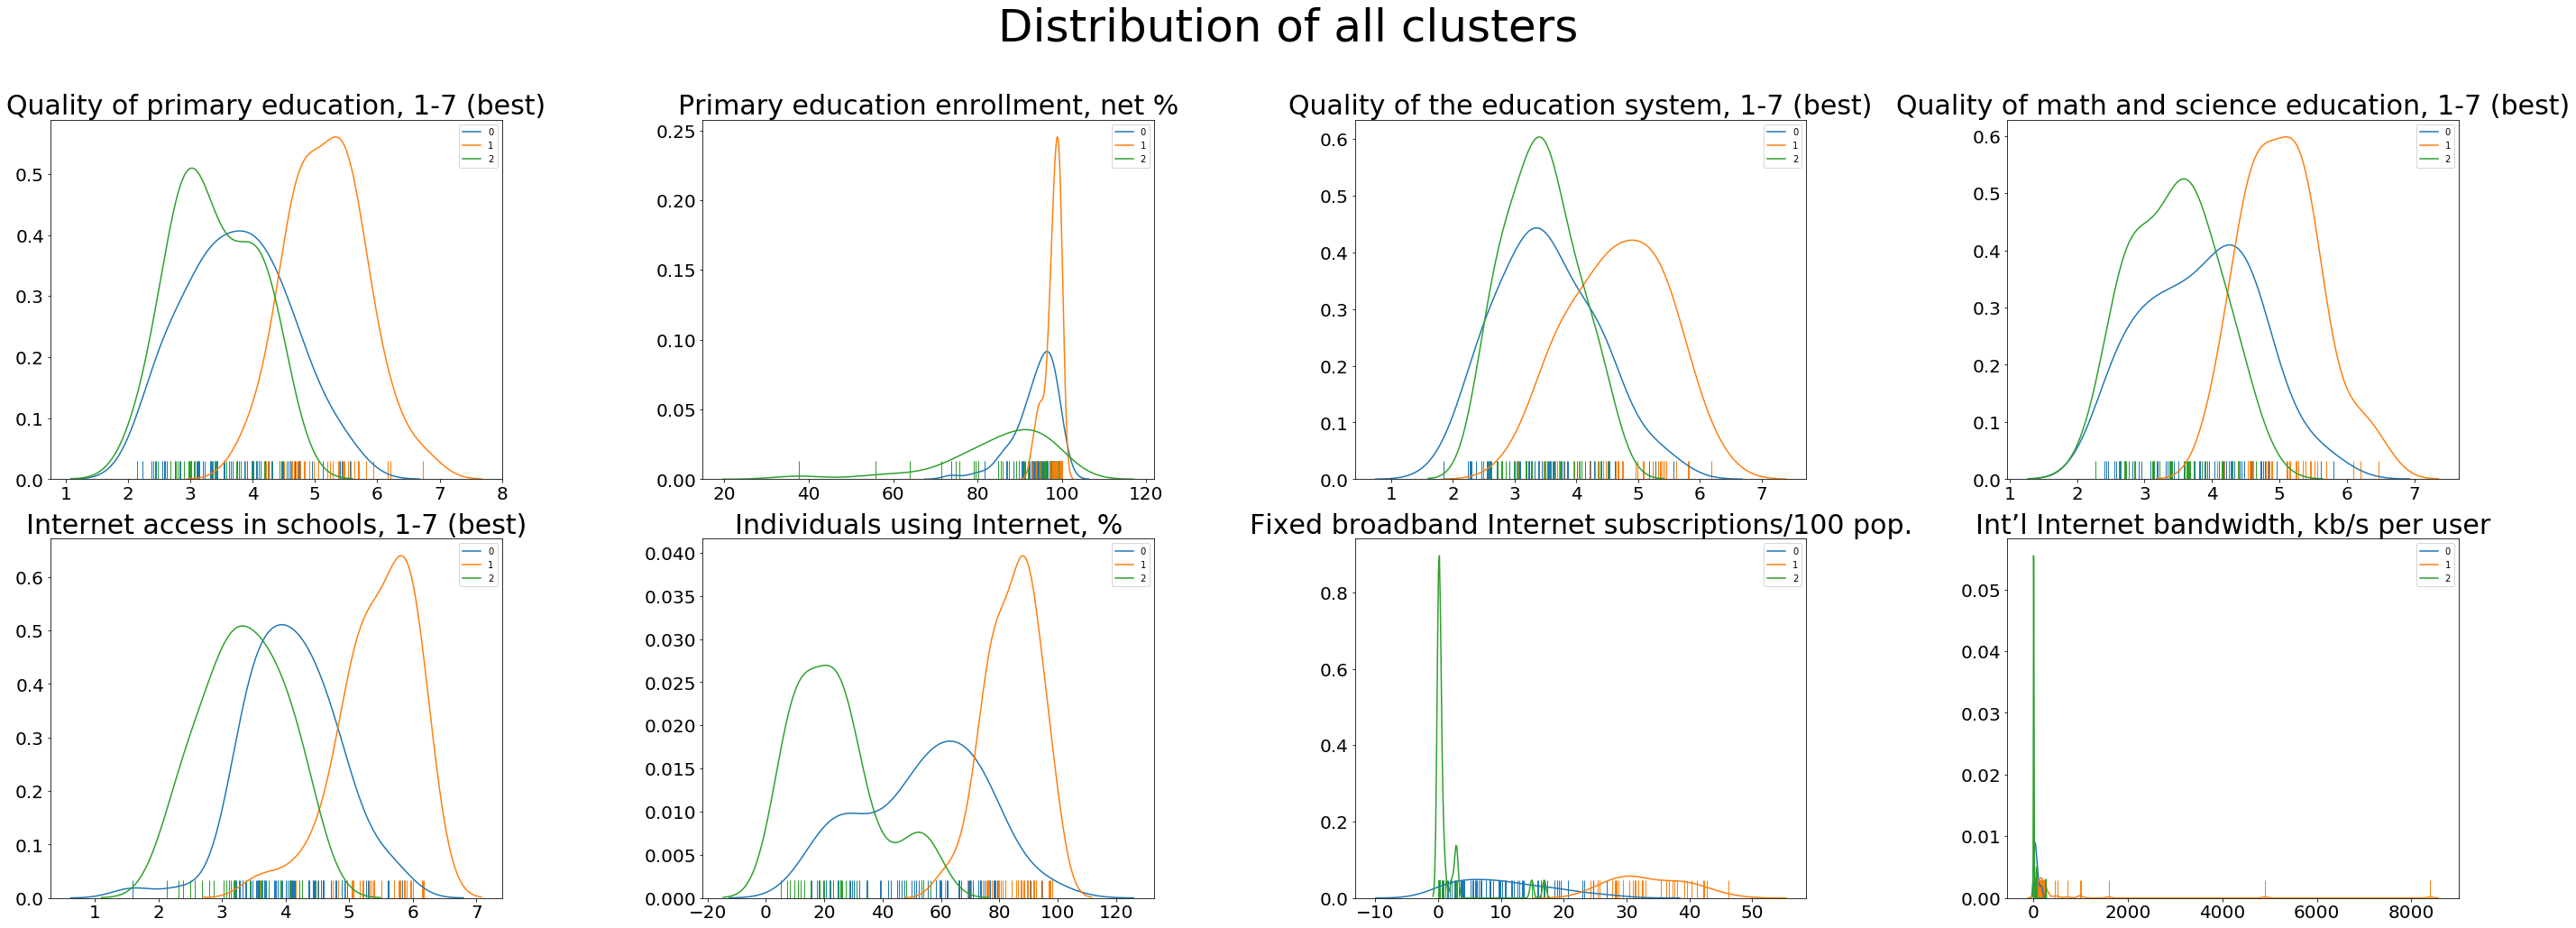

In [33]:
fig, axes = plt.subplots(2, 4, figsize=(40,15))


for attribute, ax in zip(attribute_val, axes.flatten()):
    for i, target in enumerate(targets):
        #for name in list('')
        sns.distplot(target[[attribute]], hist=False, rug=True, label = i, ax = ax)\
        .set_title(attribute, fontsize = 30)
    # chart params
    #ax.set_title('{}'.format(val), fontsize = 30, fontweight='bold')
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    
fig.tight_layout(rect=[0, 0.03, 1, 0.9])
fig.suptitle('Distribution of all clusters', fontsize = 50)
plt.show()
    

## Visualize clusters

In [34]:
# make prediction into categorical data for visualization
conditions = [
    (data_predicted['prediction'] ==0),
    (data_predicted['prediction'] == 1),
    (data_predicted['prediction'] == 2)]

# create a list of the values we want to assign for each condition
values = ['Low edu - Mid internet', 'High edu - High internet', 'Low edu - Low internet']

data_predicted['cluster'] = np.select(conditions, values)


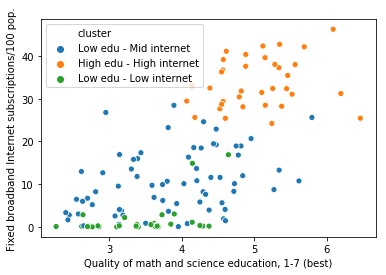

In [35]:
ax = sns.scatterplot(x="Quality of math and science education, 1-7 (best)", y="Fixed broadband Internet subscriptions/100 pop.", hue="cluster",
                     data=data_predicted)

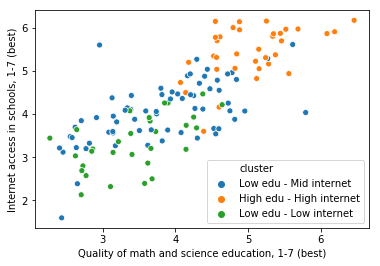

In [36]:
ax = sns.scatterplot(x="Quality of math and science education, 1-7 (best)", y="Internet access in schools, 1-7 (best)", hue="cluster",
                     data=data_predicted)